# Multi-Armed Bandit Line Jump

In this notebook, we test our knowledge of multi-armed bandits on the a line wark problem. The formulation of a line walk problem is as follows:
- We have a line scaled from 0 to $\texttt{max\_scale}$.
- We set sample random two variables $\texttt{agent\_position}$ and $\texttt{goal}$ in the line scale. These are:
    - $\texttt{agent\_position}$: our agent position
    - $\texttt{goal}$: our goal position
- We can perfom a jump from a set of n jumps which basically determines how the agent towards to the goal.
- Objective: Find the jump to makes the agent reach the goal (or at least be the closest possible).

### Import

In [24]:
import time
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(int(time.time()))
%matplotlib inline

## Environment

We start by creating the environment which is a fairly simple one.
- We generate the goal and the agent position
- Our reward at a given time step is given by:

$$ P_t = \frac{1}{|\texttt{agent\_positon}_t - \texttt{goal}| + 1}$$

$$

R_t = X \sim \mathrm{Bern}(P_t)
$$

In [25]:
class LineWalkEnvironment:
    def __init__(self, max_scale, **kwargs) -> None:
        self.max_scale = max_scale
        self.goal = np.random.randint(0, self.max_scale)
        self.agent_position = self.get_new_agent_position(self.max_scale, self.goal)
        
    def get_new_agent_position(self, max_scale, goal):
        # sample the position of the agent while 
        # excluding the goal position
        tmp = list(range(max_scale))
        tmp.remove(goal)
        return np.random.choice(tmp)
    
    def get_reward(self, step):
        agent_position = self.agent_position + step
        return 1 / (np.abs(self.goal - agent_position) + 1)
        
    def jump(self, step):
        """We jump according to a bernoulli distribution"""
        reward = self.get_reward(step)
        
        if np.random.random() < reward:
            return 1
        else:
            return 0

## Agent

- The only information our greedy agent has is:
    - The set of actions it can perform.
    - The expected gain of each action along over time.
- We update our expected reward for each action according to the following formula.

$$
Q_t(a)=\frac{R_1+R_2+\cdots+R_{N_t(a)}}{N_t(a)}
$$

- To compute it recursively, we use the following formula.

$$
Q_t(a)= Q_{t - 1}(a)+ \frac{1}{N_t(a)} (R_{N_t(a)} - Q_{t - 1}(a))
$$

In [26]:

class Jumper:
    def __init__(self, allowed_jumps, timesteps, environment, epsilon = 0, **kwargs) -> None:
        assert 0 <= epsilon <= 1.0
        
        self.reward = 0
        self.epsilon = epsilon
        self.timesteps = timesteps
        self.environment = environment
        self.allowed_jumps = allowed_jumps
        
        self.actions_counts = [0] * len(allowed_jumps)
        self.rewards_per_timesteps = np.zeros(self.timesteps)
        assert isinstance(allowed_jumps, list) and len(allowed_jumps) > 1
        self.expected_rewards = [np.random.random() for _ in range(len(self.allowed_jumps))]

    def jump(self):
        if np.random.random() > self.epsilon:
            step_idx = np.argmax(self.expected_rewards)
        else:
            step_idx = np.random.randint(len(self.allowed_jumps))
            
        reward = self.environment.jump(self.allowed_jumps[step_idx])
        
        # update the cumulative reward of our agent
        # by recursively computing the average
        self.actions_counts[step_idx] += 1  
        self.expected_rewards[step_idx] = self.expected_rewards[step_idx] + (1.0 / self.actions_counts[step_idx]) * (reward - self.expected_rewards[step_idx])
        
        return reward
    
    def explore(self):
        
        for step in range(1, self.timesteps + 1):
            reward = self.jump()
            self.reward = self.reward + (1.0 / step) * (reward - self.reward)
            self.rewards_per_timesteps[step - 1] = self.reward

## Training

Now, let us create the function that runs the different experiments and returns the metrics of interest to compare different methods. We implement these experiments such that $10^{th}$ action is always the best action.

In [33]:

def run_experiments(agents_specs, timesteps, num_actions, num_experiments, line_scale):
    best_action_index_new = -1
        
    agents = {
        agent: {
            "params": specs["params"], #  parameters of the learning agent
            "color": specs["color"], # color for visualization
            "average_reward_per_timesteps": np.zeros(timesteps),
            "average_reward_per_actions": np.zeros(num_actions),
            } for agent, specs in agents_specs.items()
        }
    
    for idx in range(1, num_experiments + 1):
    
        env = LineWalkEnvironment(line_scale)

        # create available 10 jumps such that 
        # there exists only few possible jumps 
        actions = np.random.randint(-line_scale, line_scale, num_actions)
        
        # sort action in increasing reward 
        rewards_per_actions = np.vectorize(lambda action: env.get_reward(action))(actions)
        sorted_actions_index = np.argsort(rewards_per_actions)
        actions = actions[sorted_actions_index]
        
        for name in agents:
            # create a new agent for each experiment
            # all agent interact on the same environment (but not at once).
            agent = Jumper(list(actions), timesteps, env, **agents[name]["params"])
            agent.explore()
            
            # update metrics average over experiments
            agents[name]["average_reward_per_timesteps"] = agents[name]["average_reward_per_timesteps"] + (1.0 / idx) * (agent.rewards_per_timesteps - agents[name]["average_reward_per_timesteps"])
            agents[name]["average_reward_per_actions"] = agents[name]["average_reward_per_actions"] + (1.0 / idx) * (agent.expected_rewards - agents[name]["average_reward_per_actions"])
            
    return agents
        

The next steps is to run a simulation with different approach to solving the multi-armed bandit problem. These approaches are:
    
- Greedy Solution (only select best action)
- $\epsilon$-greedy (select best action with probability 1 - $\epsilon$)

In [34]:
num_actions = 10
line_scale = 256
timesteps = 1000
num_experiments = 2000

specs = {
    "$\epsilon=0.1$": {
        "params": {
            "epsilon": 0.1
        },
        "color": "black"
    },
    "$\epsilon=0.01$": {
        "params": {
            "epsilon": 0.01
        },
        "color": "red"
    },
    "$\epsilon=0$ (greedy)": {
        "params": {
            "epsilon": 0.0
        },
        "color": "green"
    },
}

results = run_experiments(specs, timesteps, num_actions, num_experiments, line_scale)

<Figure size 640x480 with 0 Axes>

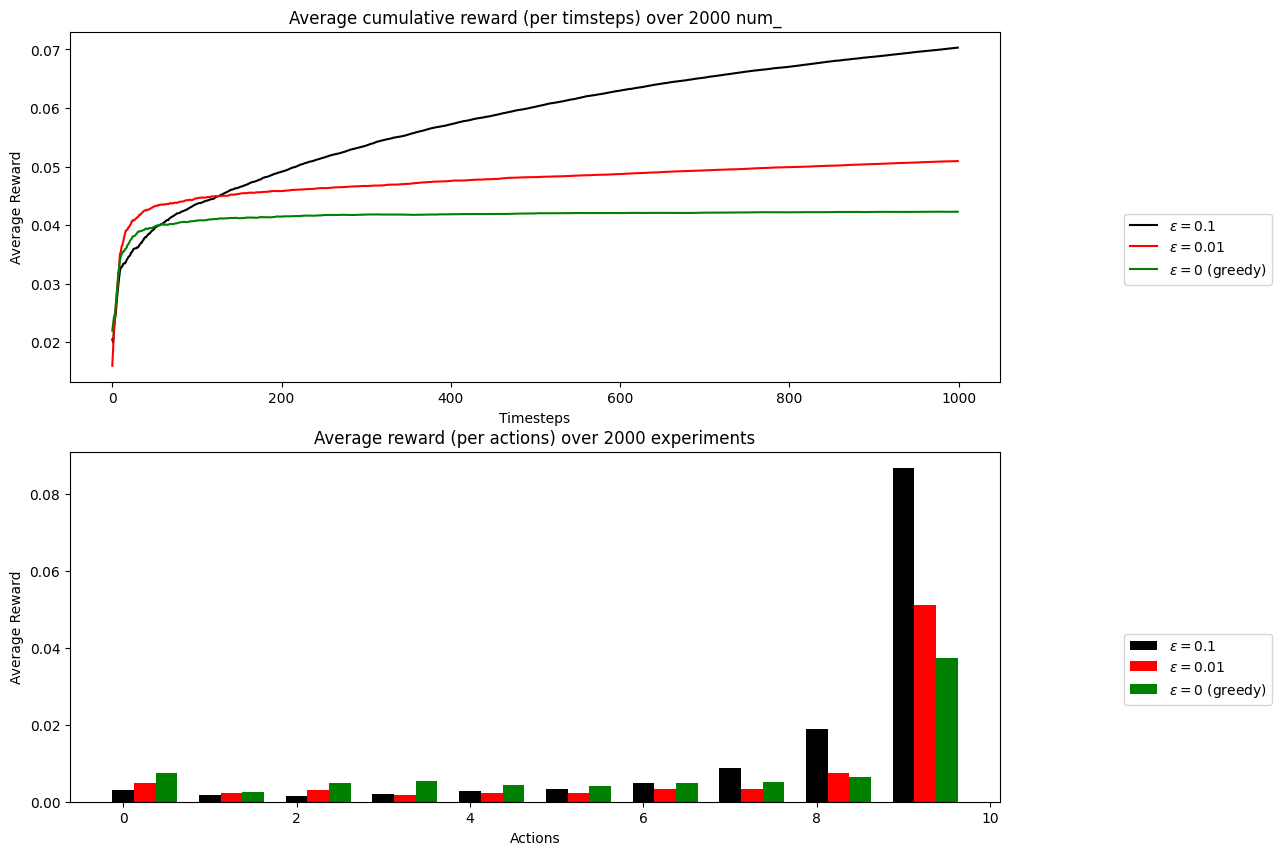

In [35]:
plt.tight_layout(pad=20.0)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# average reward per timesteps
for name in results:
    ax[0].plot(range(timesteps), 
               results[name]["average_reward_per_timesteps"],
               color=results[name]["color"],
               label=name)
    
ax[0].set_title(f'Average cumulative reward (per timsteps) over {num_experiments} num_')
ax[0].set_xlabel('Timesteps')
ax[0].set_ylabel('Average Reward')
ax[0].legend(bbox_to_anchor=(1.3, 0.5))

bins = np.linspace(0, num_actions - 1, num_actions)
width = 0.25
offset = 0

# Average reward expectation of the model per timesteps
for name in results:
    ax[1].bar(bins + offset*width, 
              results[name]["average_reward_per_actions"], 
              color=results[name]["color"],
              label=name,
              width=width)
    offset += 1

ax[1].set_title(f'Average reward (per actions) over {num_experiments} experiments')
ax[1].set_xlabel('Actions')
ax[1].set_ylabel('Average Reward')
ax[1].legend(bbox_to_anchor=(1.3, 0.5))